# Analyze Sentiment for Forum Data
This notebook loads the sentiment data and explores results

## Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind, kde
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import math
from statsmodels.formula.api  import ols
from scraping import create_connection

## Functions

In [ ]:
def ttest_sentiment(df, v):
    """ run a t-test on the sentiment scores for
        before and during the pandemic
    :param df: data frame
    :param v: the variable name to t-test on
    :return: nothing, prints ttest results
    """
    group_before = df.where(df['before'])[v].dropna()
    group_during = df.where(df['during'])[v].dropna()
    result = ttest_ind(group_before, group_during, equal_var=False, nan_policy="omit")
    print('\n')
    l = len(v)
    print(' '*(l - 8) + 'variable    before    during statistic    pvalue')
    print(v + '  {:1.6f}  {:1.6f} {:+1.6f}  {:1.6f}'.format(group_before.mean(), group_during.mean(), result.statistic, result.pvalue))

In [17]:
def create_dates(df):
    """ create date variables
    :param df: data frame
    :return: formatted data frame
    """
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['before'] = df['date_created'] <= pd.Timestamp(2020,2,28)
    df['during'] = df['date_created'] >= pd.Timestamp(2020,4,1)
    df['march'] = ~df['before'] & ~df['during']
    df.loc[df['before'], 'period'] = 'before'
    df.loc[df['march'], 'period'] = 'march'
    df.loc[df['during'], 'period'] = 'during'
    df['weekday'] = df['date_created'].dt.day_name()
    df['week_n'] = df['date_created'].dt.isocalendar().week
    df['weekday_n'] = df['date_created'].dt.day
    df['month'] = df['date_created'].dt.month_name()
    df['month_n'] = df['date_created'].dt.month
#     df['ymd'] = df['date_created'].dt.to_period('D')
    return df

In [ ]:
def compare_parent_child(df):
    parents = df[df["is_parent"]]
    parents = parents[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children = df[~df["is_parent"]]
    children = children[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children_ave = children.groupby("family_id", as_index=False).mean()
    compare = pd.merge(left=parents, right=children_ave, on="family_id", how="inner", suffixes=['_p','_c'])
    compare['pos_diff'] = compare['pos_sentiment_p'] - compare['pos_sentiment_c']
    compare['neg_diff'] = compare['neg_sentiment_p'] - compare['neg_sentiment_c']
    compare['compound_diff'] = compare['compound_sentiment_p'] - compare['compound_sentiment_c']
    return compare

In [ ]:
def season_sentiment(df, name, var):
    grouping_ave = df.groupby([var])['compound_sentiment'].mean()
    path_sen = path_parent / "clean_data" / "sentiment_{0}_{1}.csv".format(name, var)
    path_sen = str(path_sen)
    grouping_ave.to_csv(path_sen)
    print(grouping_ave)

In [ ]:
def season_freq(df, name, var):
    grouping_freq = df.groupby(var)[var].count()
    path_freq = path_parent / "clean_data" / "frequency_{0}_{1}.csv".format(name, var)
    path_freq = str(path_freq)
    grouping_freq.to_csv(path_freq)
    print(grouping_freq)

In [36]:
def ave_sent_day(df):
    daily_ave = df[['date_created','com_sentiment']].copy()
    daily_ave = daily_ave.set_index('date_created')
    daily_ave = daily_ave.resample('D').mean().dropna(how='all')
    daily_ave['period'] = "March"
    daily_ave.loc[daily_ave.index <= pd.Timestamp(2020,2,28), 'period'] = "Before"
    daily_ave.loc[daily_ave.index >= pd.Timestamp(2020,4,1), 'period'] = "During"
    return daily_ave

In [40]:
def daily_freq(df):
    freq = df[['date_created', 'com_sentiment']].copy()
    freq = freq.set_index('date_created')
    freq = freq.resample('D').size().dropna(how='all').to_frame()
    freq.columns = ['daily_count']
    freq['period'] = "March"
    freq.loc[freq.index <= pd.Timestamp(2020,2,28), 'period'] = "Before"
    freq.loc[freq.index >= pd.Timestamp(2020,4,1), 'period'] = "During"
    return freq

In [18]:
def filter_dates(df, start, end):
    mask = (df['date_created'] >= start) & (df['date_created'] < end)
    return df.loc[mask]

## File Locations

In [2]:
p = Path.cwd()
path_parent = p.parents[0]

In [3]:
path_db = path_parent / "database" / "netmums-merged.db"
path_db = str(path_db)
# path_counts = path_parent / "clean_data" / "subforum-counts.csv"
# path_counts = str(path_counts)
# path_sn = path_parent / "clean_data" / "sn_sentiment.csv"
# path_td = path_parent / "clean_data" / "td_sentiment.csv"

## Load Data

In [4]:
conn = create_connection(path_db)

Counts of posts in each subforum

In [5]:
counts_sql = '''
    SELECT f.id, COUNT(p.id), MIN(date_created), MAX(date_created)
    FROM posts AS p
    LEFT JOIN threads AS t
    ON t.id=p.thread_id
    LEFT JOIN subforums AS s
    ON s.id=t.subforum_id
    LEFT JOIN forums AS f
    ON f.id=s.forum_id
    GROUP BY f.id
'''
counts = pd.read_sql_query(counts_sql, conn)

In [6]:
counts

,id,COUNT(p.id),MIN(date_created),MAX(date_created)
0,1,34742,2007-10-20 07:40PM,2021-02-26 10:53PM
1,2,2793434,2005-11-10 01:40PM,2021-03-05 12:03PM
2,3,2629988,2005-06-24 05:57PM,2021-03-07 11:31AM
3,4,235676,2005-11-08 07:39PM,2021-02-28 09:51PM
4,5,2188663,2005-09-19 08:08PM,2021-03-04 08:14AM
5,6,99384,2006-12-30 01:09AM,2021-02-12 11:34AM
6,7,7925,2020-01-28 06:48PM,2021-02-27 04:33PM
7,8,95001,2008-10-26 11:06PM,2021-02-26 08:26PM
8,9,995689,2005-10-13 09:54PM,2021-03-04 09:36PM
9,10,23102,2005-12-27 05:36PM,2021-03-05 07:42AM


Special needs subforum

In [29]:
sn_sql = '''
    SELECT
        p.id AS post_id,
        p.date_created AS date_created,
        p.thread_id AS thread_id,
        s.neg_sen_clean as neg_sentiment,
        s.neu_sen_clean as neu_sentiment,
        s.pos_sen_clean as pos_sentiment,
        s.com_sen_clean as com_sentiment
    FROM sentiment AS s
    LEFT JOIN posts AS p
    ON p.id = s.post_id
    LEFT JOIN threads AS t
    ON t.id=p.thread_id
    LEFT JOIN subforums AS s
    ON s.id=t.subforum_id
    LEFT JOIN forums AS f
    ON f.id=s.forum_id
    WHERE f.id=24
'''

In [30]:
sn = pd.read_sql_query(sn_sql, conn)

In [31]:
sn = create_dates(sn)

In [ ]:
sn.to_csv(path_sn, index=False)

Toddler subforum: generate a 10% sample of family_ids to make processing easier

In [ ]:
td_ids_sql = ''' SELECT family_id FROM threads WHERE subforum="toddler" '''

In [ ]:
conn = create_connection(path_db)

In [ ]:
td_ids = pd.read_sql_query(td_ids_sql, conn)

In [ ]:
id_10per_sample = td_ids.sample(frac = 0.1, random_state = 281)

In [ ]:
id_10per_sample.info()

In [ ]:
temp_table_sql = ''' 
    CREATE TEMPORARY TABLE
        temp(id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, family_id INTEGER);
    '''

In [ ]:
cur = conn.cursor()
cur.execute(temp_table_sql)

In [ ]:
id_10per_sample.to_sql('temp', conn, if_exists='append', index=False)

In [ ]:
# posts: message_id (merge var), date_created, parent_id
# sentiment: message_id (merge var), *_sen_* (sentiment variables)
td_sql = '''
    SELECT
        p.message_id AS message_id,
        p.date_created AS date_created,
        p.parent_id AS parent_id,
        s.neg_sen_all as neg_sen,
        s.neu_sen_all as neu_sen_all,
        s.pos_sen_all as pos_sen_all,
        s.com_sen_all as com_sen_all,
        s.neg_sen_no_url as neg_sen_no_url,
        s.neu_sen_no_url as neu_sen_no_url,
        s.pos_sen_no_url as pos_sen_no_url,
        s.com_sen_no_url as com_sen_no_url
    FROM posts AS p
    JOIN sentiment AS s
    ON p.message_id = s.message_id
    WHERE p.family_id IN (SELECT family_id FROM temp)
'''

In [ ]:
td = pd.read_sql_query(td_sql, conn)

In [ ]:
# drop temp table
conn.close()

In [ ]:
td = create_dates(td)

In [ ]:
td.to_csv(path_td, index=False)

## Compare Sentiment

### 1. Subsets in correct date range: 2018-01-01 to 2020-11-30

In [32]:
# td_sub = filter_dates(td, pd.Timestamp(2014, 1, 1, 0, 0, 0), pd.Timestamp(2020, 12, 1, 0, 0, 0))
sn_sub = filter_dates(sn, pd.Timestamp(2014, 1, 1, 0, 0, 0), pd.Timestamp(2020, 12, 1, 0, 0, 0))

### 2. Comparing sentiment before and during pandemic with a t-test

In [ ]:
for name, df in {"Special Needs":sn_sub, "Toddler":td_sub}.items():
    print(name)
    ttest_sentiment(df, 'neg_sen_no_url')
    ttest_sentiment(df, 'neu_sen_no_url')
    ttest_sentiment(df, 'pos_sen_no_url')
    ttest_sentiment(df, 'com_sen_no_url')
    print("\n")

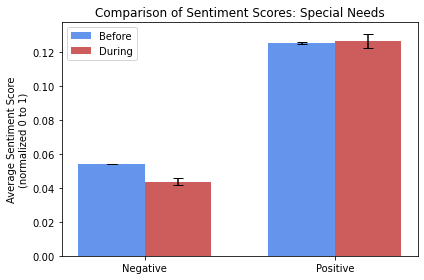

In [33]:
# for name, df in {"Special Needs":sn_sub, "Toddler":td_sub}.items():
for name, df in {"Special Needs":sn_sub}.items():
    fig, ax = plt.subplots()
    width = 0.35
    sentiments = ['Negative', 'Positive']
    x_pos = np.arange(len(sentiments))

    before_mean = [df["neg_sentiment"][df['before']].mean(),
                   df["pos_sentiment"][df['before']].mean()]
    before_se = [df["neg_sentiment"][df['before']].std()/math.sqrt(len(df["neg_sentiment"][df['before']])),
                 df["pos_sentiment"][df['before']].std()/math.sqrt(len(df["pos_sentiment"][df['before']]))]
    during_mean = [df["neg_sentiment"][df['during']].mean(),
                   df["pos_sentiment"][df['during']].mean()]
    during_se = [df["neg_sentiment"][df['during']].std()/math.sqrt(len(df["neg_sentiment"][df['during']])),
                 df["pos_sentiment"][df['during']].std()/math.sqrt(len(df["pos_sentiment"][df['during']]))]

    rects_before = ax.bar(x_pos - width/2, before_mean, width, yerr=before_se,
                    label='Before', capsize=5, color="cornflowerblue")
    rects_during = ax.bar(x_pos + width/2, during_mean, width, yerr=during_se,
                    label='During', capsize=5, color="indianred")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Sentiment Score\n(normalized 0 to 1)')
    ax.set_title('Comparison of Sentiment Scores: {}'.format(name))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sentiments)
    ax.legend()
    fig.tight_layout()
#     plt.savefig('../plots/sentiment_neg_pos.png')
    plt.show()

### 3. Comparing sentiment of parent and child posts

In [ ]:
for df in [sn_sub, td_sub]:
    print("\nGROUP\n")
    compare = compare_parent_child(df)
    est_pos = ols(formula = 'pos_sentiment_c ~ pos_sentiment_p', data = compare).fit()
    print(est_pos.summary())
    est_neg = ols(formula = 'neg_sentiment_c ~ neg_sentiment_p', data = compare).fit()
    print(est_neg.summary())
    est_compound = ols(formula = 'compound_sentiment_c ~ compound_sentiment_p', data = compare).fit()
    print(est_compound.summary())

So this suggests if a parent comment's negative sentiment increases, the children's negative sentiment will increase as well. Perhaps redo this analysis on each observation rather than the average children's sentiment.

### 4. Compare density of compound sentiment

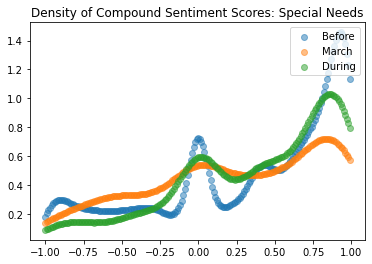

In [34]:
# for name, df in {"Special Needs":sn_sub, "Toddler":td_sub}.items():
for name, df in {"Special Needs":sn_sub}.items():
    density_before = kde.gaussian_kde(df["com_sentiment"][df['before']])
    density_march = kde.gaussian_kde(df["com_sentiment"][df['march']])
    density_during = kde.gaussian_kde(df["com_sentiment"][df['during']])
    x = np.arange(-1.0, 1.0, 0.01)
    plt.scatter(x, density_before(x), alpha=0.5, label="Before")
    plt.scatter(x, density_march(x), alpha=0.5, label="March")
    plt.scatter(x, density_during(x), alpha=0.5, label="During")
    plt.legend(loc="upper right")
    plt.title('Density of Compound Sentiment Scores: {}'.format(name))
    plt.show()

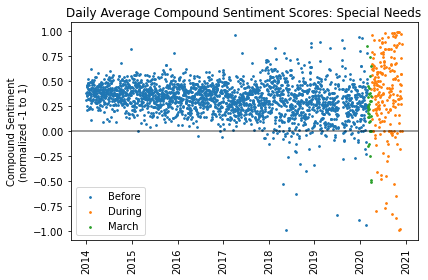

In [38]:
size = 3
# for name, df in {"Special Needs":sn, "Toddler":td_sub}.items():
for name, df in {"Special Needs":sn_sub}.items():
    daily_ave = ave_sent_day(df)
    groups = daily_ave.groupby('period')
    for period, group in groups:
        plt.scatter(group.index, group.com_sentiment, label=period, s=size)
    plt.legend(loc="lower left")
    plt.xticks(rotation=90)
    plt.ylabel('Compound Sentiment\n(normalized -1 to 1)')
    plt.title('Daily Average Compound Sentiment Scores: {}'.format(name))
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()

### 5. Compare post frequency over same period for special needs and toddler subforums

Frequency

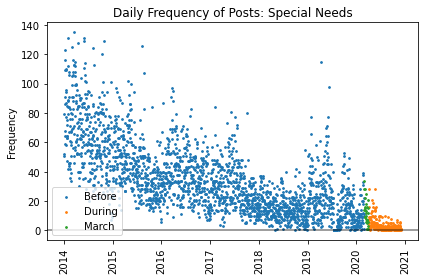

In [41]:
size = 3
# for name, df in {"Special Needs":sn, "Toddler":td_sub}.items():
for name, df in {"Special Needs":sn_sub}.items():
    freq = daily_freq(df)
    groups = freq.groupby('period')
    for period, group in groups:
        plt.scatter(group.index, group.daily_count, label=period, s=size)
    plt.legend(loc="lower left")
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.title('Daily Frequency of Posts: {}'.format(name))
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()

### 6. Compare within-individual sentiment over time

In [ ]:
# average sentiment by months/quarters/years since first participation???